__Chapter 11 - Working with Unlabeled Data – Clustering Analysis__

1. [Import](#Import)
1. [Cluster analysis](#cluster-analysis)
1. [Grouping objects by similarity using k-means](#Grouping-objects-by-similarity-using-k-means)
    1. [A smarter way of placing the initial cluster centroids using k-means++](#A-smarter-way-of-placing-the-initial-cluster-centroids-using-k-means++)
    1. [Hard versus soft clustering](#Hard-versus-soft-clustering)
1. [Using the elbow method to find the optimal number of clusters](#Using-the-elbow-method-to-find-the-optimal-number-of-clusters)
1. [Quantifying the quality of clustering via silhouette plots](#Quantifying-the-quality-of-clustering-via-silhouette-plots)
1. [Organizing clusters as a hierarchical tree](#Organizing-clusters-as-a-hierarchical-tree)
    1. [Grouping clusters in bottom-up fashion](#Grouping-clusters-in-bottom-up-fashion)
    1. [Performing hierarchical clustering on a distance matrix](#Performing-hierarchical-clustering-on-a-distance-matrix)
    1. [Attaching dendrograms to a heat map](#Attaching-dendrograms-to-a-heat-map)
    1. [Applying agglomerative clustering via scikitlearn](#Applying-agglomerative-clustering-via-scikit-learn)
1. [Locating regions of high density via DBSCAN](#Locating-regions-of-high-density-via-DBSCAN)
    


# Import

<a id = 'Import'></a>

In [1]:
# standard libary and settings
import os
import sys
import importlib
import itertools
from io import StringIO
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.base as base
import sklearn.cluster as cluster
import sklearn.datasets as datasets
import sklearn.decomposition as decomposition
import sklearn.ensemble as ensemble
import sklearn.feature_extraction as feature_extraction
import sklearn.feature_selection as feature_selection
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import sklearn.neighbors as neighbors
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm
import sklearn.tree as tree
import sklearn.discriminant_analysis as discriminant_analysis
import sklearn.utils as utils

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

# custom extensions and settings
sys.path.append("/home/mlmachine") if "/home/mlmachine" not in sys.path else None
sys.path.append("/home/prettierplot") if "/home/prettierplot" not in sys.path else None

import mlmachine as mlm
from prettierplot.plotter import PrettierPlot
import prettierplot.style as style

# magic functions
%matplotlib inline

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Cluster analysis

If we do not know the labels for our observations, we can use cluster analysis, which is a category of unsupervised learning, to discover hidden structures in data. The goal is to find natural grouping in data so that items of the same cluster are more similar to each other than to those in different clusters.

<a id = 'cluster-analysis'></a>

# Grouping objects by similarity using k-means

k-means is a clustering technique that has many different applications. To name a few, it can be used to group documents, music, movies by topic, customers with similar interests, and much more.

k-means is easy to implement in scikit-learn and is also computationally very efficient compared to other clustering algorithms. It is a 'prototype-based' clustering technique. Two other types of clustering to be covered later are 'hierarchical clustering' and 'density-based clustering'.

'Prototype-based' clustering means that each cluster is defined by a prototype. This can be the centroid (average) of similar points when working with number variables, or the medoid (the most frequently occuring point) when working with object features.

One drawback of k-means is that we need to define 'k', or the number of clusters, beforehand. To measure the quality of clusters, we can use the elbow method and silhouette plots.

<a id = 'Grouping-objects-by-similarity-using-k-means'></a>

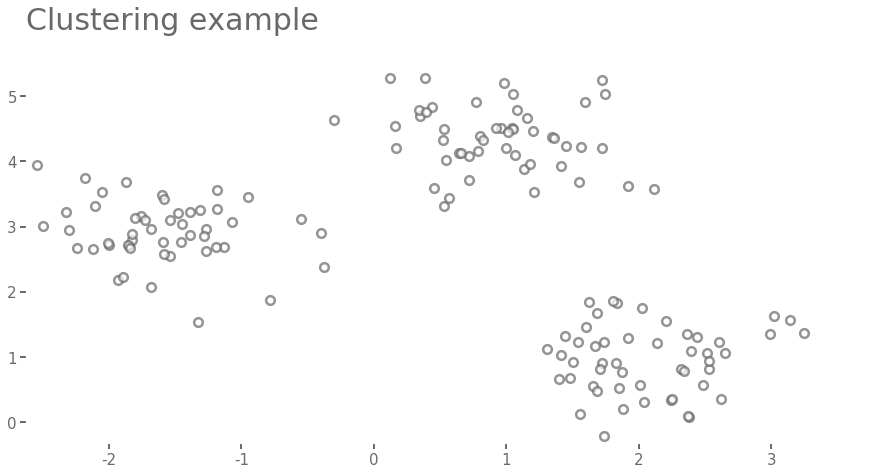

In [2]:
# plot 150 random points that are roughly grouped into 3 regions
X, y = datasets.make_blobs(
    n_samples=150,
    n_features=2,
    centers=3,
    cluster_std=0.5,
    shuffle=True,
    random_state=0,
)

p = PrettierPlot()
ax = p.make_canvas(title="Clustering example")
p.pretty_2d_scatter(x=X[:, 0], y=X[:, 1], x_units="f", y_units="f", ax=ax)

To group observations into cluster, we need to identify samples with feature similarities. K-means achieves this by:

1. Randomly pick $k$ centroids as the initial cluster centers
2. Assign each samples to the nearest centroid $\mu^j, j \in \{1,...,k\}$
3. Move the centroid to the center of the samples that were assigned to it
4. Repeat steps 2 and 3 until the cluster assignments do not change or a user-defined tolerance or maximum # of iterations is reached.

To measure similarity, we use a distance calculation. The shorter the distance between two observations the more similar they are thought to be. A commonly used distance measure for clustering samples with number features is the squared Euclidean distance. The Euclidean distance between two points x and y in $m$-dimensional space is definedas:

$$
d(\textbf{x},\textbf{y}) = \sum^m_{j=1}\big(x_j-y_j\big)^2 = \Vert{\textbf{x} - \textbf{y}}\Vert_2^2
$$

Index $j$ refers to the $j$th dimension (feature column) of the sample points x and y.

k-means minimizes the within-cluster Sum of Squared Errors (SSE), which is also called the cluster intertia:

$$
SSE = \sum^n_{i=1}\sum^k_{j=1}w^{(i,j)}\Vert{\textbf{x}^i - \mathbf{\mu}^j}\Vert^2_2
$$

$\mathbf{\mu}^j$ is the centroid for cluster $j$, and $w^{(i,j)}$ = 1 if the sample $\textbf{x}^i$, and otherwise 0.

In [3]:
# fit KMeans model with 3 clusters
km = cluster.KMeans(
    n_clusters=3, init="random", n_init=10, max_iter=100, tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

> Remarks - We decide beforehand that we want to define 3 clusters. n_init = 10 means the k-means clustering algorithm 10 times independently with different random centroids and then chooses the final model as the one with the lowest SSE. The paramers max_iter and tol define how long the algorithm runs. It's possible for one or more clusters to be empty. A cluster is empty when all points are closer to another centroid. When this happens, scikit-learn's k-means implementation will search for the samples that is farthest away from the empty cluster, then reassign the empty cluster's centroid to this farthest point.

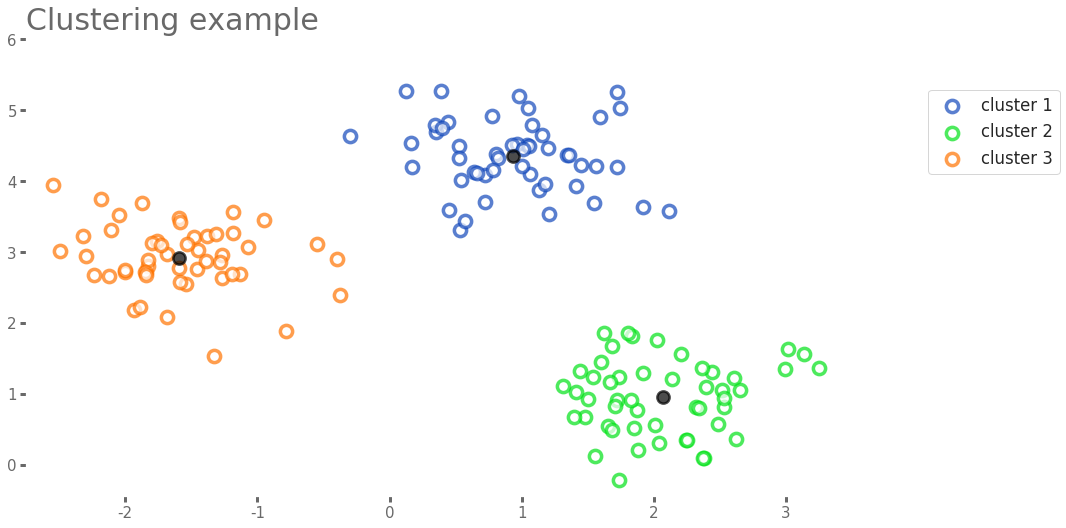

In [4]:
# visualize learned clusters
Xs = np.hstack((X[y_km == 0, 0], X[y_km == 1, 0], X[y_km == 2, 0]))
ys = np.hstack((X[y_km == 0, 1], X[y_km == 1, 1], X[y_km == 2, 1]))
ls = np.hstack((y_km[y_km == 0], y_km[y_km == 1], y_km[y_km == 2]))

p = PrettierPlot()
ax = p.make_canvas(title="Clustering example")
p.pretty_2d_scatter_hue(
    x=Xs,
    y=ys,
    target=ls,
    label=["cluster 1", "cluster 2", "cluster 3"],
    x_units="f",
    y_units="f",
    bbox=(1.2, 0.9),
    ax=ax,
)

p.pretty_2d_scatter(
    x=km.cluster_centers_[:, 0],
    y=km.cluster_centers_[:, 1],
    axis_limits=False,
    color="black",
    facecolor=None,
    ax=ax,
)

## A smarter way of placing the initial cluster centroids using k-means++

Traditional k-means randomly chooses (or relies on a random-seed) the initial cluster centroids, which means k-means' success may vary. k-means++ improves on this drawback by placing the initial centroids far away from each other, which leads to better and more consistent results. The k-means++ initialization can be summarized as follows:

1. Initialize an empty set of $\textbf{M}$ to sore the $k$ centroids being selected.
2. Randomly choose the first centroid  $\mathbf{\mu}^j$ from the input samples and assign it to  $\textbf{M}$.
3. For each sample  $\textbf{x}^i$ that is not in  $\textbf{M}$, find the minimum squared distance  $d\big(\textbf{x}^i,\textbf{M}\big)^2$ to any of the centroids in M
4. Randomly select the next centroid $\mathbf{\mu}^p$ using a weighted probability distribution equal to $\frac{d\big(\mathbf{\mu}^j, \mathbf{M}\big)}{\sum_id\big(x^i, \mathbf{M}\big)^2}$
5. Repeat steps 2 and 3 until k centroids are chosen
6. Then proceed with the classic k-means algorithm.

k-means++ is built into scikit-learn's KMeans object, and we just need to set the init parameter to 'k-means++'

<a id = 'A-smarter-way-of-placing-the-initial-cluster-centroids-using-k-means++'></a>

## Hard versus soft clustering

Hard clustering algorithms assign each sample in a dataset to exactly one cluster. k-means is a hard clustering algorithm. Soft clustering, or fuzzy clustering, assign samples to one or more clusters. A popular example of this is fuzzy C-means (FCM). The process is similar to k-means, but the major change is that rather than providing a hard cluster assignment, each sample is assigned a probability of belonging to a cluster.



<a id = 'Hard-versus-soft-clustering'></a>

# Using the elbow method to find the optimal number of clusters

One of the main challenges in unsupervised learning is that we do not know the definitive answer. Without the ground truth, we cannot emply tactics like grid search and cross validation to evaluate a model. Instead, we can quantify the quality of clusters using intrinsic metrics, such as the within-cluster SSE (distortion).

Using the within-cluster SSE, we can use the elbow method, which is a graphical tool for estimating the optimal number of clusteres $k$. Intuitively, as $k$ increases, the distortion decreases because the samples will be closer to their assigned centroids. The idea behind the elbow method is to identify the value of $k$ where the distrotion begins to increase most rapidly.

<a id = 'Using-the-elbow-method-to-find-the-optimal-number-of-clusters'></a>

In [5]:
# evluate model's interita/distortion
print("Distortion: {}".format(km.inertia_))

Distortion: 72.47601670996698


In [6]:
# calculate distortion for increasing values of k
distortions = []
for i in range(1, 11):
    km = cluster.KMeans(
        n_clusters=i, init="k-means++", n_init=10, max_iter=300, random_state=1
    )
    km.fit(X)
    distortions.append(km.inertia_)

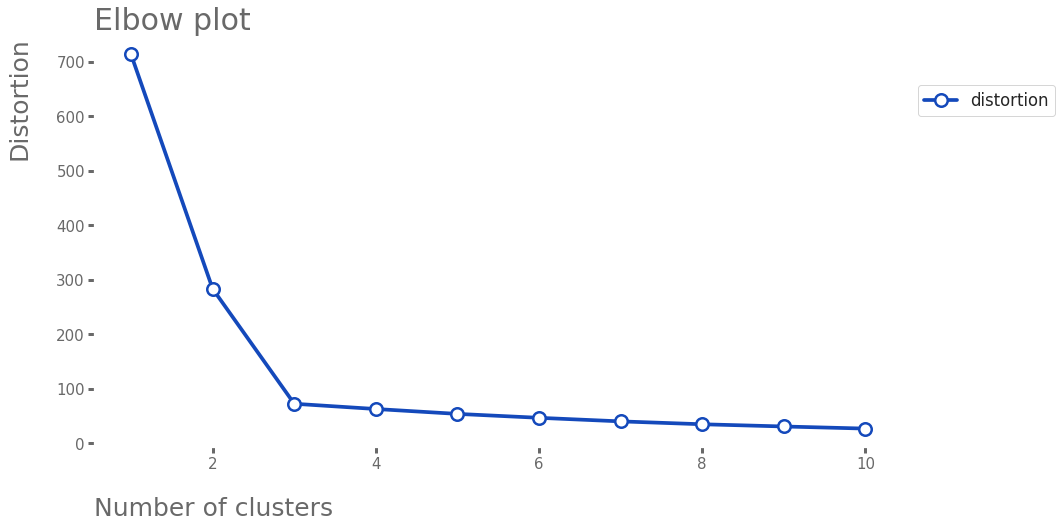

In [7]:
# visualize ideal value of K with elbow plot
p = PrettierPlot()
ax = p.make_canvas(
    title="Elbow plot", x_label="Number of clusters", y_label="Distortion", y_shift=0.7
)
p.pretty_multi_line(
    x=np.arange(1, 11),
    y=np.array(distortions),
    label=["distortion"],
    x_units="f",
    y_units="f",
    bbox=(1.2, 0.9),
    marker_on=True,
    ax=ax,
)

> Remarks - The elbow of the plot occurs at $k$ = 3.

# Quantifying the quality of clustering via silhouette plots

Silohouette analysis is another technique for evaluating the quality of clustering. It can be applied to clustering algorithms other than k-means. Silhouette analysis is a graphical tool for plotting a measure of how tightly grouped the samples in a cluster are. Calculating the silhouette coefficient of a single sample involves three steps:

1. Calculate the cluster cohesion $a^i$ as the average distance between a sample $\textbf{x}^i$ and all other points in the same cluster.
2. Calculate the cluster separation $b^i$ from the next closest cluster as the average distance between the sample $\textbf{x}^i$ and all other points in the nearest cluster.
3. Calculate the silhouette $s^i$ as the difference between cluster cohesion and separation divided by the greater of the two 

$$
s^i = \frac{b^i - a^i}{\mbox{max}\{b^i,a^i\}}
$$

The coefficient is bounded in the range -1 to 1. Intuitively, if the coefficient is 0 if the cluster separation and cohesion values are equal $(b^i = a^i)$. The ideal silhouette coefficient of 1 occurs is $b^i >> a^i$, because $b^i$ quantifies how dissimilar a sample is to other clusters, and $a^i$ describes how similar a sample is to other samples in its own cluster.

<a id = 'Quantifying-the-quality-of-clustering-via-silhouette-plots'></a>

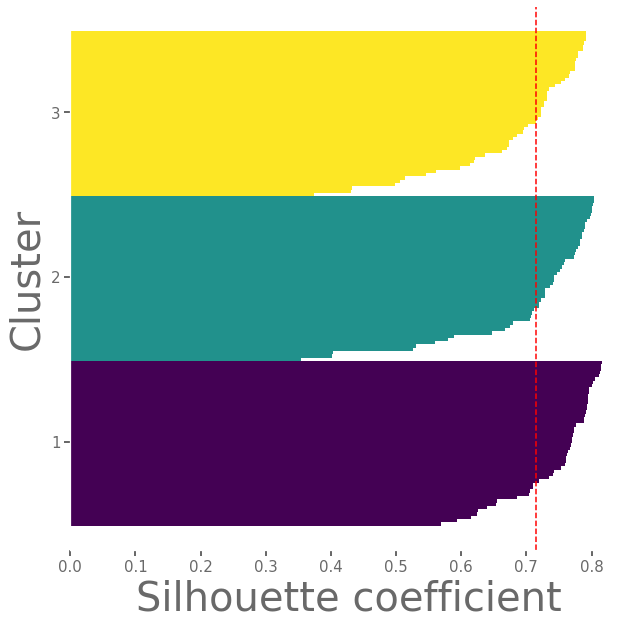

In [6]:
# fit model
km = cluster.KMeans(
    n_clusters=3, init="k-means++", n_init=10, max_iter=300, tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

from matplotlib import cm

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = metrics.silhouette_samples(X, y_km, metric="euclidean")

# colors
color_list = style.colorGen(num=len(cluster_labels))

# visualize results using silhouette plot
y_ax_lower, y_ax_upper = 0, 0
yticks = []
plt.figure(figsize=(10, 10))
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)

    plt.barh(
        range(y_ax_lower, y_ax_upper),
        c_silhouette_vals,
        height=1.0,
        edgecolor="none",
        color=color_list[i],
    )
    yticks.append((y_ax_lower + y_ax_upper) / 2.0)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)

plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel("Cluster")
plt.xlabel("Silhouette coefficient")
plt.show()

> Remarks - Each sample is represented by a bar, and all bars within each cluster are sorted and grouped together. It's clear that none of the silhouette coefficients are close to 0, which indicates good clustering. If the clusters were suboptimal, we would see much shorter coefficents among one or more of the cluster groups.

# Organizing clusters as a hierarchical tree

Hierarchical clustering is an alternativeto prototype-based clustering. One advantage is that hierarchical clustering results can be plotted as a dendrogram, which is a visualization of a binary hierarchical clustering). This can help with the interpretation of the results by creating meaningful taxonomies. We also don't need to specify the number of clusters up front.

There are two different approaches to hierarchical clustering - agglomerative and divisive. In divisive clustering, we start with one cluster which includes all of our samples, and iteratively split the cluster into smaller clusters until each cluster only contains on sample.  Agglomerative clustering is the opposite - we start with each sample as an individual cluster and merge the closest pairs of clusters together until only one cluster remains.

<a id = '-clusters-as-a-hierarchical-tree'></a>

## Grouping clusters in bottom-up fashion

The two standard algorithms for agglomerative hierarchical clustering are single linkage and complete linkage. With single linkage, we compute the distances between the most similar member for each pair of clusters and merge the two clusters for which the distance between the most similar members is smallest. Complete linkage is similar but instead compares the most dissimilar members of each cluster to perform the merge.

As an example, we will use agglomerative clustering using complete linkage. It can be summarized by the following steps:

1. Compute the distance matrix of all samples
2. Represent each data point as a singleton cluster
3. Merge the two closest clusters based on the distance between the most dissimilar, or distant members.
4. Update the similarity matrix
5. Repeat steps 2-4 until one single cluster remains.


<a id = 'Grouping-clusters-in-bottom-up-fashion'></a>

In [7]:
# generate random data: the rows represent observations and the columns are features
np.random.seed(123)
variables = ["X", "Y", "Z"]
labels = ["ID_0", "ID_1", "ID_2", "ID_3", "ID_4"]
X = np.random.random_sample([5, 3]) * 10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


## Performing hierarchical clustering on a distance matrix

We need to calculate the Euclidean distance between each pair of sample points based on the features X, Y and Z.


<a id = 'Performing-hierarchical-clustering-on-a-distance-matrix'></a>

In [8]:
# for illustrative purposes, calculate squareform distance matrix
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(
    squareform(pdist(df, metric="euclidean")), columns=labels, index=labels
)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


Then we need to use SciPy's linkage function to return a linkage matrix. Care must be taken to ensure this is executed properly. We would be incorrect to use the square form matrix

In [9]:
# incorrect approach, don't do this
from scipy.cluster.hierarchy import linkage

row_clusters = linkage(row_dist, method="complete", metric="euclidean")
row_clusters

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


array([[ 0.        ,  4.        ,  6.52197264,  2.        ],
       [ 1.        ,  2.        ,  6.72960262,  2.        ],
       [ 3.        ,  5.        ,  8.53924727,  3.        ],
       [ 6.        ,  7.        , 12.44482356,  5.        ]])

In [10]:
# Correct approach 1
from scipy.cluster.hierarchy import linkage

row_clusters = linkage(pdist(df, metric="euclidean"), method="complete")
row_clusters

array([[0.        , 4.        , 3.83539555, 2.        ],
       [1.        , 2.        , 4.34707339, 2.        ],
       [3.        , 5.        , 5.89988504, 3.        ],
       [6.        , 7.        , 8.31659367, 5.        ]])

In [11]:
# Correct approach 2
from scipy.cluster.hierarchy import linkage

row_clusters = linkage(df.values, method="complete", metric="euclidean")
row_clusters

array([[0.        , 4.        , 3.83539555, 2.        ],
       [1.        , 2.        , 4.34707339, 2.        ],
       [3.        , 5.        , 5.89988504, 3.        ],
       [6.        , 7.        , 8.31659367, 5.        ]])

In [12]:
# create data frame of results
pd.DataFrame(
    row_clusters,
    columns=["row label 1", "row label 2", "distance", "no. of items in clust."],
    index=["cluster %d" % (i + 1) for i in range(row_clusters.shape[0])],
)

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.000000,4.000000,3.835396,2.000000
cluster 2,1.000000,2.000000,4.347073,2.000000
cluster 3,3.000000,5.000000,5.899885,3.000000
cluster 4,6.000000,7.000000,8.316594,5.000000


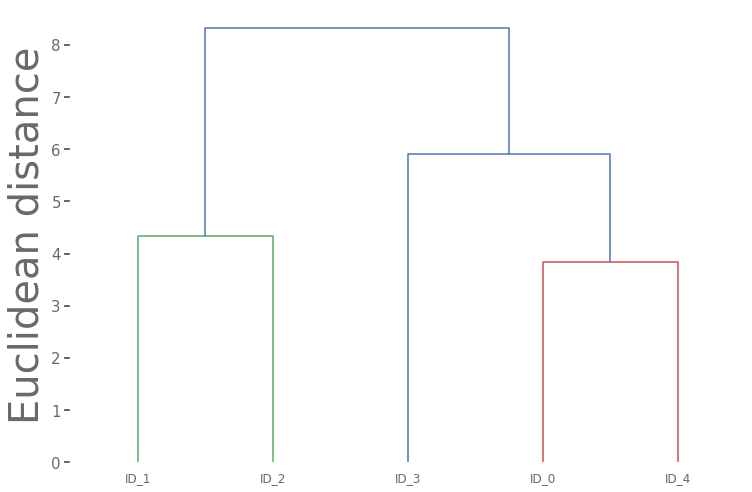

In [13]:
# visualize in a dendrogram
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(10, 7))
row_denr = dendrogram(row_clusters, labels=labels)
plt.tight_layout()
plt.ylabel("Euclidean distance")
plt.show()

> Remarks - This dendrogram summarizes the different clusteres that were formed during the agglomerative hierarchical cluster. We can see that the samples ID_0 and ID_4 followed by ID_1 and ID_2 are most similar based on Euclidean distance.

## Attaching dendrograms to a heat map

Hierarchical clustering dendrograms are often used in combination with a heat map, which associated individual values with a color code.

<a id = 'Attaching-dendrograms-to-a-heat-map'></a>

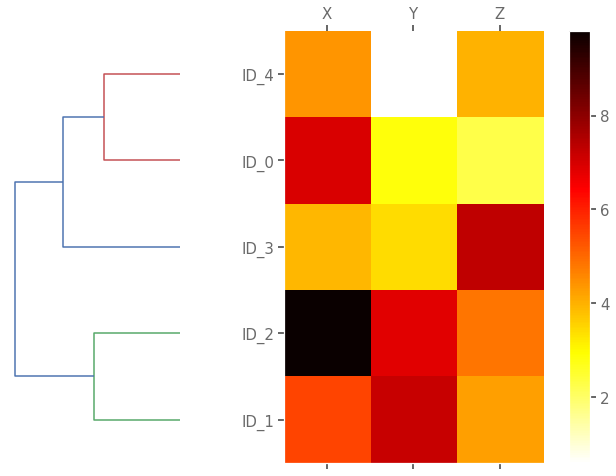

In [14]:
# rotate dendrogram 90 degrees counter-clockwise and
# create a figure object and define the x axis position, y axis position,
# width and height of the dendrogram
fig = plt.figure(figsize=(12, 10), facecolor="white")
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])
row_dendr = dendrogram(row_clusters, orientation="left")

# reorder the data based on cluster labels
df_rowclust = df.iloc[row_dendr["leaves"][::-1]]

# construct the heat map from the reordered dataframe and place
# it next to the dendrogram
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])
cax = axm.matshow(df_rowclust, interpolation="nearest", cmap="hot_r")

# turn off axis ticks and hide axis spines
# add a color bar and assign feature and sample names
axd.set_xticks([])
axd.set_yticks([])
for i in axd.spines.values():
    i.set_visible(False)

fig.colorbar(cax)
axm.set_xticklabels([""] + list(df_rowclust.columns))
axm.set_yticklabels([""] + list(df_rowclust.index))
plt.show()

> Remarks - from this visual we can see the dendrogram along with a table that associated a color code with the value of a particular feature for a sample.

## Applying agglomerative clustering via scikitlearn

The previous section using SciPy to perform agglomerative hierarchical clustering. There is an implementation in scikit-learn as well, and this allows us to choose the number of clusters. This parameter lets us prune the tree if needed.

<a id = 'Applying-agglomerative-clustering-via-scikit-learn'></a>

In [15]:
# create agglomerative clustering model with 3 clusters
ac = cluster.AgglomerativeClustering(
    n_clusters=3, affinity="euclidean", linkage="complete"
)
labels = ac.fit_predict(X)
print("Cluster labels: {0}".format(labels))

Cluster labels: [1 0 0 2 1]


> Remarks - Just as with Scipy, ID_0 and ID_4 are clusted together, and so are ID_1 and ID_2. ID_3 is in its own cluster. With SciPy, would were able to observe that ID_3 is closest to ID_4 and ID_0, and this isn't something we can do with scikit-learn.

In [16]:
# create agglomerative clustering model with 3 clusters
ac = cluster.AgglomerativeClustering(
    n_clusters=2, affinity="euclidean", linkage="complete"
)
labels = ac.fit_predict(X)

print("Cluster labels: {0}".format(labels))

Cluster labels: [0 1 1 0 0]


> Remarks - By limiting to 2 clusters, this effectively prunes the hierarchy and returns fewer clusters.

# Locating regions of high density via DBSCAN

Density-based spatial clustering of applications with noise (DBSCAN) does not make assumptions about spherical clusters like k-means, and it doesn't partition the dataset into hierarchies that require a manual cut-off point. Instead, density-based clustering assigns cluster labels based on dense regions of points. Density is defined as the number of points within a specified radius $\epsilon$.

Per the DBSCAN algorithm, a special label is assigned to each sample by the following criteria:

1. A point is considered a core point if at least a specified number (MinPoints) of neighboring points fall within the specified radius $\epsilon$
2. A border point is a point that has fewer neighors than the number specified as MinPoints within $\epsilon$, but itself lies within the $\epsilon$ of a core point.
3. All other points that are neither core nor border points are considered noise points.

After applying one of these three labels to each sample, the DBSCAN algorithm can be summarized as:

1. Form a separate cluster for each core point or connected group of core points (core points become connected if they are no farther away than the $\epsilon$ value.
2. Assign each border point to the cluster of its corresponding core point

Two of the main benefits of DBSCAN is that it does not assume spherical shapes of clusters and it does not necessarily have to assign each point to a cluster. A point can just be noise.

<a id = 'Locating-regions-of-high-density-via-DBSCAN'></a>

In [17]:
# fit DBSCAN model
X, y = datasets.make_moons(n_samples=200, noise=0.05, random_state=0)

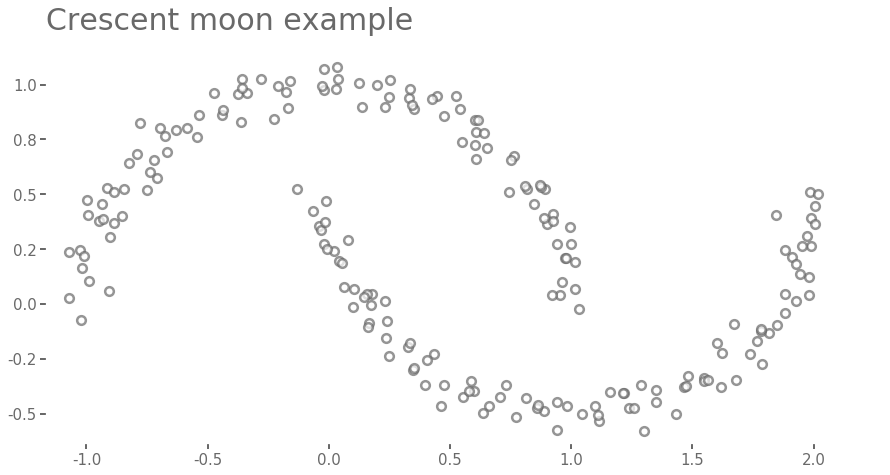

In [18]:
# display crescent moon data set
p = PrettierPlot()
ax = p.make_canvas(title="Crescent moon example")
p.pretty_2d_scatter(
    x=np.array(X[:, 0]), y=np.array(X[:, 1]), x_units="ff", y_units="ff", ax=ax
)

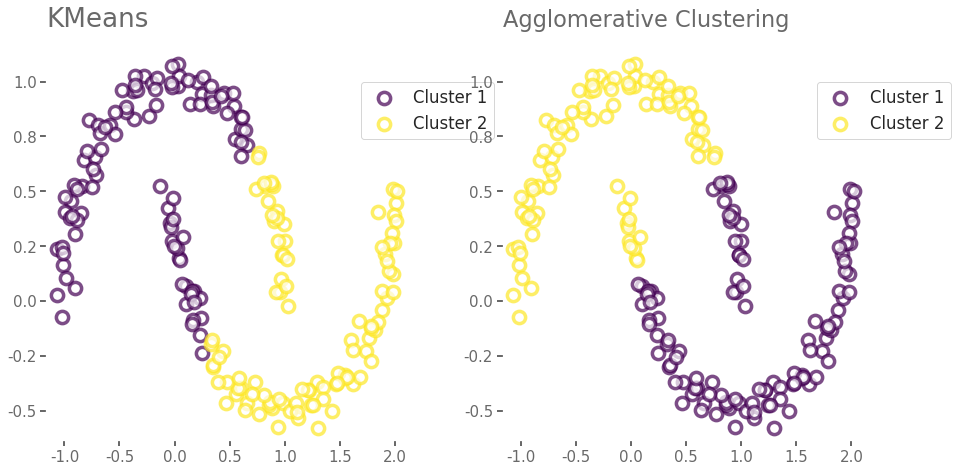

In [19]:
# visualize KMeans vs agglomerative clustering
p = PrettierPlot()

km = cluster.KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)
Xs = np.hstack((X[y_km == 0, 0], X[y_km == 1, 0]))
ys = np.hstack((X[y_km == 0, 1], X[y_km == 1, 1]))
ls = np.hstack((y_km[y_km == 0], y_km[y_km == 1]))

ax = p.make_canvas(title="KMeans", position=121)
p.pretty_2d_scatter_hue(
    x=Xs,
    y=ys,
    target=ls,
    label=["Cluster 1", "Cluster 2"],
    x_units="ff",
    y_units="ff",
    bbox=(1.2, 0.9),
    ax=ax,
)
ax = p.make_canvas(title="Agglomerative Clustering", position=122)
ac = cluster.AgglomerativeClustering(
    n_clusters=2, affinity="euclidean", linkage="complete"
)
y_ac = ac.fit_predict(X)
Xs = np.hstack((X[y_ac == 0, 0], X[y_ac == 1, 0]))
ys = np.hstack((X[y_ac == 0, 1], X[y_ac == 1, 1]))
ls = np.hstack((y_ac[y_ac == 0], y_ac[y_ac == 1]))
p.pretty_2d_scatter_hue(
    x=Xs,
    y=ys,
    target=ls,
    label=["Cluster 1", "Cluster 2"],
    x_units="ff",
    y_units="ff",
    bbox=(1.2, 0.9),
    ax=ax,
)

> Remarks - Neither KMeans nor agglomerative clustering does well with these non-spherical clusters.

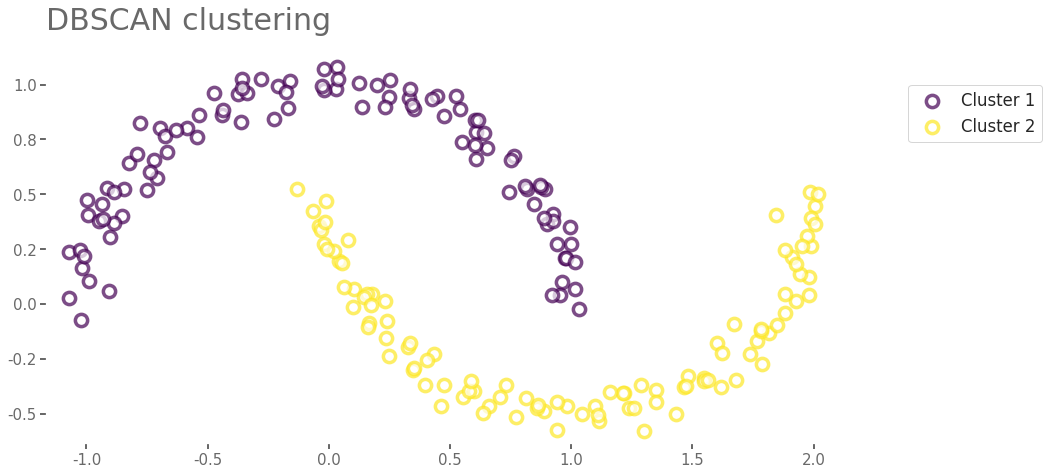

In [20]:
# visualize DBSCAN results
db = cluster.DBSCAN(eps=0.2, min_samples=5, metric="euclidean")
y_db = db.fit_predict(X)
Xs = np.hstack((X[y_db == 0, 0], X[y_db == 1, 0]))
ys = np.hstack((X[y_db == 0, 1], X[y_db == 1, 1]))
ls = np.hstack((y_db[y_db == 0], y_db[y_db == 1]))

p = PrettierPlot()
ax = p.make_canvas(title="DBSCAN clustering", position=111)
p.pretty_2d_scatter_hue(
    x=Xs,
    y=ys,
    target=ls,
    label=["Cluster 1", "Cluster 2"],
    x_units="ff",
    y_units="ff",
    bbox=(1.2, 0.9),
    ax=ax,
)

> Remarks - Much better. It's worth mentioning the downside associated with DBSCAN. As features increase, assuming a fixed number of training samples, the negative effect of the curse of dimensionality increases. This is especially a problem when using Euclidean distance. It's worth mentioning the curse of dimensionality affects other clustering algorithms as well. Another drawback of DBSCAN is that both MinPts and $\epsilon$ are both parameters that need to be tuned. Finding a good combinations can be problematic if the density differences in the dataset are relatively large.